# Face Recognition Application

This application showcases how we can use the rorodata platform to train an application for the purpose of facial recognition using transfer learning. 

We use a pre-trained network that has been trained on a dataset of faces and thus does not require any further training to detect facial features. All we need to do to repurpose the network for our use is to fine-tune the final dense layers.

Since the output of the network will be softmax probabilities, we will need some threshold values for confidence on whether the detected image belongs to a certain class or not.

## The Dataset to train on

Since we will be using the keras [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) API to perform image augmentation and pass the augmented images to the network training call, we will use the training/testing directory structure expected by it. 

Under the `data` folder we will have the `train` and `test` folders, each containing individual folders containing training/testing images, where the folder name would determine the class labels.

For our application, we will train the model to recognize 3 celebrities - Denzel Washington, Shakira and Robert Downey Jr.

The directory structure for our dataset will be the following:

```
data
└── train
    ├── denzel_washington
    │   ├── 1.jpeg
    │   ├── 10.jpeg
    │   ├── 11.jpeg
    │   ├── 12.jpeg
    │   ├── 13.jpeg
    │   ├── 14.jpeg
    │   ├── 15.jpg
    │   ├── 2.jpg
    │   ├── 3.jpeg
    │   ├── 4.jpeg
    │   ├── 5.jpeg
    │   ├── 6.jpeg
    │   ├── 7.jpeg
    │   ├── 8.jpeg
    │   └── 9.jpeg
    ├── robert_downey_jr
    │   ├── 1.jpeg
    │   ├── 10.jpeg
    │   ├── 11.jpeg
    │   ├── 12.jpeg
    │   ├── 13.jpeg
    │   ├── 14.jpeg
    │   ├── 15.jpeg
    │   ├── 2.jpg
    │   ├── 3.jpeg
    │   ├── 4.jpeg
    │   ├── 5.jpeg
    │   ├── 6.jpeg
    │   ├── 7.jpeg
    │   ├── 8.jpeg
    │   └── 9.jpeg
    └── shakira
        ├── 1.jpg
        ├── 10.jpeg
        ├── 11.jpg
        ├── 12.jpeg
        ├── 13.jpeg
        ├── 14.jpg
        ├── 15.jpeg
        ├── 2.jpeg
        ├── 3.jpeg
        ├── 4.jpeg
        ├── 5.jpeg
        ├── 6.jpeg
        ├── 7.jpeg
        ├── 8.jpeg
        └── 9.jpeg
```


Each class contains 15 images that we will use for training.

In [1]:
import joblib
import os
import sys
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

%matplotlib inline

In [2]:
class_dirs = glob('/volumes/data/data/train/*')

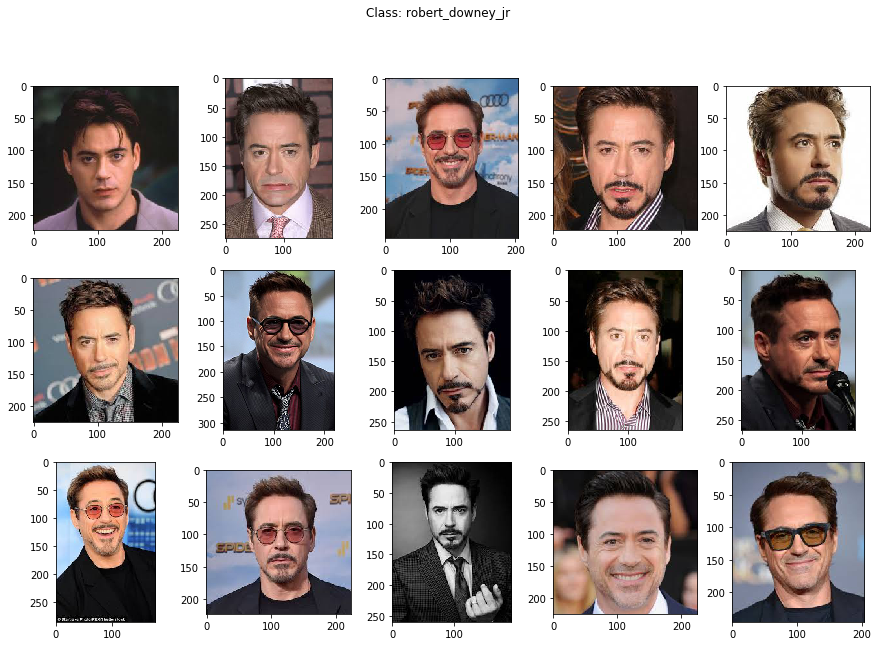

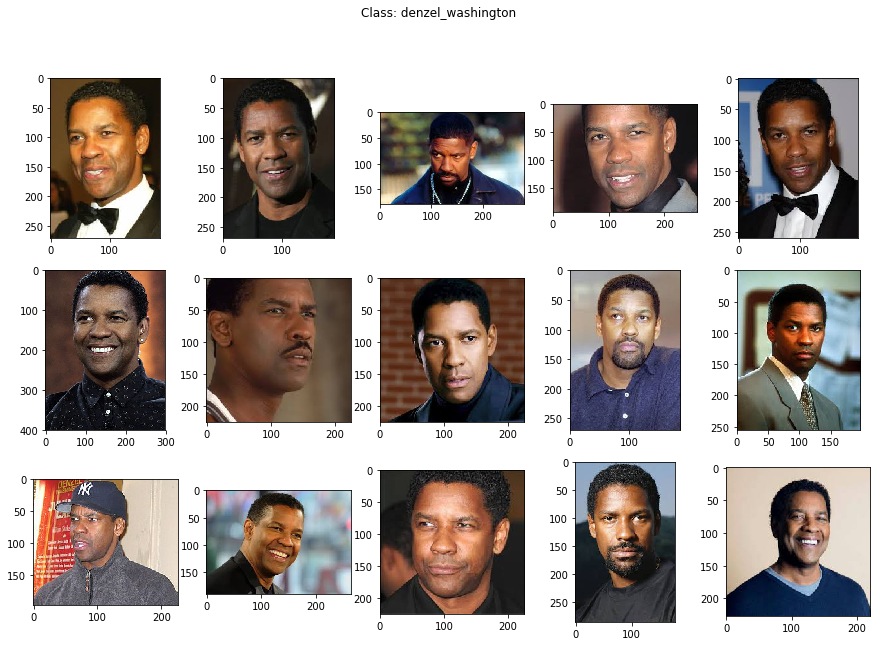

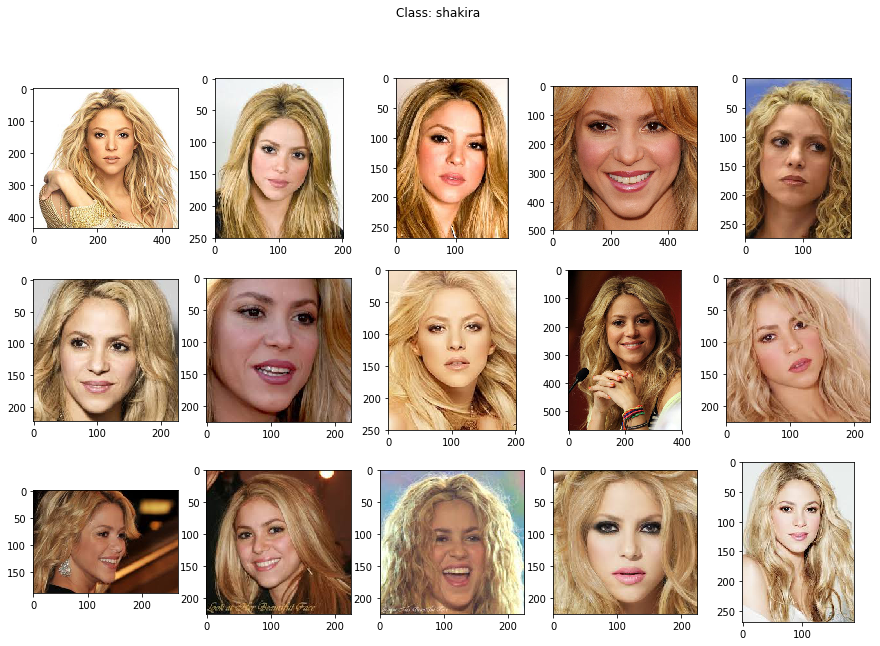

In [3]:
for class_dir in class_dirs:
    label = os.path.basename(class_dir)
    plt.figure(figsize=(15,10))
    plt.suptitle(f'Class: {label}')
    for ix, image in enumerate(glob(class_dir + '/*')):
        image = mpimg.imread(image)
        plt.subplot(3, 5, ix+1)
        plt.imshow(image)
    

## Training the Network

### Install necessary libraries

In [4]:
!pip install keras_vggface

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import numpy as np
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.models import load_model

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### We use the keras [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) for image augmentation to help the network generalize better.

In [6]:
train_datagen = ImageDataGenerator(
        #rotation_range=40,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        rescale=1./255,
        #shear_range=0.2,
        zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='nearest')

Build the final layer of our network dynamically based upon the number of faces we want to detect. We should have at least 2 faces to detect from.

In [7]:
# Figure out how many classes there should be.
nb_class = len(os.listdir('/volumes/data/data/train'))

if nb_class < 2:
    print('There should be at least 2 classes to predict on.')
    sys.exit(1)

Next, we define our model architecture. The base model will be the same as a ResNet50 architecture with additional dense layers added for fine tuning.

In [8]:
vgg_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

last_layer = vgg_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
out = Dense(nb_class, activation='softmax', name='classifier')(x)

custom_vgg_model = Model(vgg_model.input, out)

94699520/94694792 [==============================] - 1s 0us/step


Freeze the base model weights as we are fine-tuning the network to our own training data.

In [9]:
for layer in vgg_model.layers:
    layer.trainable = False

Compile the model

In [10]:
custom_vgg_model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])

Train model.

In [11]:
batch_size = 15

train_generator = train_datagen.flow_from_directory(
        '/volumes/data/data/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

custom_vgg_model.fit_generator(
        train_generator,
        steps_per_epoch=15 // batch_size,
        epochs=100)

Found 45 images belonging to 3 classes.
Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 1.7603 - acc: 0.3333
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 11.1203 - acc: 0.1333
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 3.9430 - acc: 0.4000
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 7.5287 - acc: 0.5333
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 5.0402 - acc: 0.6667
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 2.8554 - acc: 0.8000
Epoch 7/100
1/1 [==============================] - 5s 5s/step - loss: 3.7723 - acc: 0.6000
Epoch 8/100
1/1 [==============================] - 5s 5s/step - loss: 1.3091 - acc: 0.8667
Epoch 9/100
1/1 [==============================] - 5s 5s/step - loss: 0.2824 - acc: 0.9333
Epoch 10/100
1/1 [==============================] - 5s 5s/step - loss: 1.0580 - acc: 0.8000
Epoch 11/100
1/1 [==============================

Save the entire model and also the class indices to be used in inference later.

In [12]:
train_generator.class_indices

{'denzel_washington': 0, 'robert_downey_jr': 1, 'shakira': 2}

In [13]:
joblib.dump(train_generator.class_indices, '/volumes/data/class_indices.dict')

custom_vgg_model.save('/volumes/data/vgg_model.h5')

## Testing the Model

In [14]:
import cv2 as cv

In [15]:
test_image_path = '/volumes/data/test_image.png'

In [16]:
test_image = cv.imread(test_image_path)

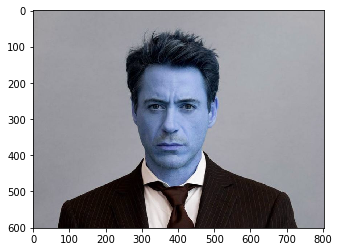

In [17]:
plt.imshow(test_image)

#### We pre-process the test image using the following function. For details please refer to: https://github.com/rcmalli/keras-vggface

In [18]:
# Function to process batch of extracted faces to a format 
# that will can be passed to the vgg_face model.

def process_images(image):
    img = cv.resize(image, (224, 224))
    
    img = img.astype(np.float32)
    
    img = utils.preprocess_input(img, version=2)
    
    return img

In [19]:
test_image_processed = process_images(test_image) 

#### Load the model and the class indices for running predictions and inference of class labels.

In [20]:
model = load_model('/volumes/data/vgg_model.h5')
class_indices = joblib.load('/volumes/data/class_indices.dict')

In [21]:
prediction = model.predict(np.expand_dims(test_image_processed, axis=0))

In [22]:
prediction

array([[0.02937167, 0.9666246 , 0.00400364]], dtype=float32)

In [23]:
class_indices

{'denzel_washington': 0, 'robert_downey_jr': 1, 'shakira': 2}

In [24]:
index_to_label = {value : key for key, value in class_indices.items()}

In [25]:
def get_prediction_label(prediction):
    prediction_index = np.argmax(prediction)
    return index_to_label[prediction_index]

In [26]:
get_prediction_label(prediction)

'robert_downey_jr'

#### Even trained on an extremely small training dataset, the model is able to predict the correct class label with extremely high accuracy.